# Make movie of an experimental campaign

Document:

- lon, lat must be "longitude", "latitude"
- drifter data must be interpolated on the movie target sampling rate, likely a bug


In [1]:
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt

import pynsitu as pin
import pynsitu.movies as movies

crs = pin.maps.crs

In [2]:
# movie parameters
dt = "10T"  # sampling rate

---
## generate sample data

In [3]:
start = "2018-01-01"
end = "2018-01-15"

extent = [4, 8, 41, 44]

lonc, latc = (extent[0] + extent[1]) * 0.5, (extent[2] + extent[3]) * 0.5
scale = 111e3


## drifters
def generate_drifter_data(drifter_id):
    """Create a drifter time series."""
    time = pd.date_range(start=start, end=end, freq="1H")
    v = 0.5  # m/s approx
    ux = v * np.random.randn(time.size)
    uy = v * np.random.randn(time.size)
    df = pd.DataFrame(dict(u=ux, v=uy, time=time))
    dt = (time[1] - time[0]) / pd.Timedelta("1s")
    df["longitude"] = lonc + df["u"].cumsum() * dt / scale / np.cos(latc * np.pi / 180)
    df["latitude"] = latc + df["v"].cumsum() * dt / scale
    # lon = v * np.cos(2 * np.pi * ((time - time[0]) / time_scale)) / scale
    # lat = v * np.sin(2 * np.pi * ((time - time[0]) / time_scale)) / scale
    # df = pd.DataFrame(dict(lon=lonc + lon, lat=latc + lat, time=time))
    df["id"] = drifter_id
    df = df.set_index("time")
    return df


dr = pd.concat([generate_drifter_data(i) for i in range(0, 5)])
# resample into target temporal resolution
dr = dr.groupby("id").apply(lambda df: df.ts.resample_uniform(dt)).droplevel(0)


## ships
def generate_ship_data():
    """Create a ship time series."""
    time = pd.date_range(start=start, end=end, freq="30T")
    time_scale = pd.Timedelta("1D")
    dl = 0.5
    lon = dl * np.cos(2 * np.pi * ((time - time[0]) / time_scale))
    lat = dl * np.sin(2 * np.pi * ((time - time[0]) / time_scale))
    df = pd.DataFrame(dict(longitude=lonc + lon, latitude=latc + lat, time=time))
    df["id"] = "myid"
    df = df.set_index("time")
    return df


ship = generate_ship_data()

## wind
dl = 0.25
wind = xr.Dataset(
    None,
    coords=dict(
        longitude=np.arange(extent[0], extent[1], dl),
        latitude=np.arange(extent[2], extent[3], dl),
        time=ship.index,
    ),
)
omega = 2 * np.pi / 5
k = 2 * np.pi / 10
U0 = 10
wind["u"] = U0 * np.cos(
    omega * (wind.time - wind.time[0]) / pin.day - k * wind.longitude
)
wind["v"] = U0 * np.sin(
    omega * (wind.time - wind.time[0]) / pin.day - k * wind.longitude
)

---

## prepare for movie generation


In [6]:
# map_gen = lambda : cp.map(extent=bounds, rivers=False, tile=("toner-lite", 12), land=False, bathy=False, coastline=False)

# or dynamic adjustment of extent
# dl = 1
# extent = (lonc - dl, lonc + dl, latc - dl, latc + df)  # fixed extent
# extent = None # dynamic adjustment of extent

# map_gen = lambda extent: pin.maps.plot_map(extent)
map_gen = lambda: pin.maps.plot_map(extent=extent, coastline="i")

# if extent is None:
#    # dynamic adjustment of extent
#    extent = dict(buffer=0.1, aspect_ratio=(2, 1), exclude=["wind"])

dr_keys = list(dr["id"].unique())
colorsd = {d: c for d, c in zip(dr_keys, pin.get_cmap_colors(len(dr_keys)))}
mv_dr = dict(
    dtype="drifter", data=dr, colors=colorsd, dt_trail="1h", head_style=dict(alpha=0.5)
)

mv_ship = dict(
    dtype="moving",
    data=ship,
    color="k",
    dt_trail="5h",
)

mv_wd = dict(
    dtype="vector_field",
    data=wind,
    u="u",
    v="v",
    uref=10,
    di=2,
    scale=1e2,
    color="0.7",
)

### instantiate movie object

In [7]:
?movies.movie

Init signature:
movies.movie(
    start,
    end,
    freq,
    map_generator,
    fig_dir,
    extent=None,
    title=None,
    extra=None,
    legend=None,
    **kwargs,
)
Docstring:     
Movie generator object

Parameters
----------
start: str or datetime-like
    Movie start time
end: str or datetime-like
    Movie end time
freq: str, datetime.timedelta, or DateOffset
    Movie snapshots frequency
map_generator: method
    Function generating a snapshot
fig_dir: str
    Path to directory where temporary figures will be generated
extent: tuple, optional
    Geographical extent
title: method, optional
    Method generating figures, should take time as an input
extra: list, optional
    List of methods adding extra information on figures.
    Method signatures must be e(t, self.data, fig, ax)
legend: str, list of str, optional
    List of labels that will legended
**kwargs: actual data of pandas or xarray, each kwarg must be a dict with
items `data` and `dtype`. `dtype` must be one of

In [8]:
mv = movies.movie(
    start,
    end,
    dt,
    map_gen,
    "figs",
    # extent=extent, #dynamic extent
    drifters=mv_dr,
    ship=mv_ship,
    wind=mv_wd,
    # legend=True,
    legend="upper right",
)

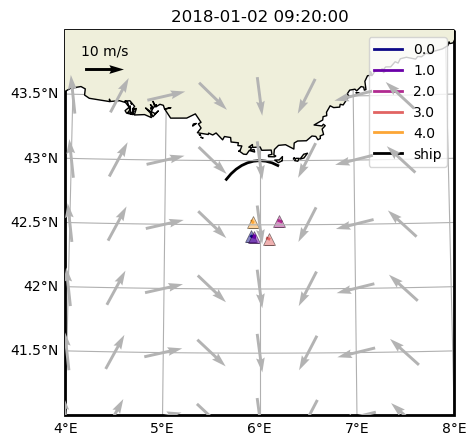

In [10]:
mv.plot_snapshot(200);

### generate movie figures

In [ ]:
mv.make_figures()

### generate movie figures withs smoothing of the geographical extent

In [32]:
extents = mv.dry_run()

# padd and smooth extents
new_extents = pad_smooth_extents(extents, 10)
# dev
# e = pd.DataFrame(padded_extents)
# ne = pd.DataFrame(new_extents)
# e[1].hvplot() * ne[1].hvplot()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 405/405 [00:18<00:00, 22.04it/s]


In [33]:
mv.make_figures(extents=new_extents)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 405/405 [10:12<00:00,  1.51s/it]


### transform figures into mp4

Requires ffmpeg to be installed, for example: `conda install ffmpeg`

In [34]:
movie.generate_mpg(mv.fig_dir, "movie")

movies should be ready at: /Users/aponte/Code/taos/insitu/taos2/taos2_drifters1.mp4
